# Questions
## 1. Which attack type would be used in the next global terrorist attack?
## 2. Which variables best predict attack type?

### Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('~/Downloads/globalterrorismdb_0617dist.csv',encoding='ISO-8859-1',low_memory = False)

In [3]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Columns: 135 entries, eventid to related
dtypes: float64(53), int64(24), object(58)
memory usage: 175.5+ MB


In [5]:
data.isnull().sum()

eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            162886
extended                   0
resolution            168131
country                    0
country_txt                0
region                     0
region_txt                 0
provstate              14502
city                     446
latitude                4606
longitude               4606
specificity                4
vicinity                   0
location              122376
summary                66138
crit1                      0
crit2                      0
crit3                      0
doubtterr                  0
alternative           143719
alternative_txt       143719
multiple                   0
success                    0
suicide                    0
attacktype1                0
attacktype1_txt            0
                       ...  
propextent            109805
propextent_txt        109805
propvalue             134863
propcomment   

### Data Cleaning

#### Remove Columns That Are Not Relevant in Predicting Attack Type Based On Our Intuitions

In [6]:
data2= data[["eventid", "iyear", "imonth", "crit1", "crit2", \
             "crit3", "doubtterr", "multiple", "country", \
             "country_txt", "region", "region_txt", "attacktype1", \
             "attacktype1_txt", "success", "weaptype1", \
             "weaptype1_txt", "suicide", \
             "targtype1", "targtype1_txt", "target1", \
             "natlty1", "gname", \
             "INT_LOG", "INT_IDEO", "latitude", "longitude"]]

#### Remove Observations Whose Exact Month of Incident is Unknown (imonth = 0)

In [7]:
data2 = data2[data2["imonth"] != 0]

In [8]:
print(data2.imonth.unique())

[ 7  1  2  3  4  5  6  8  9 10 11 12]


#### Remove Observations Whose Country is Unknown (country = Unknown)

In [9]:
data2 = data2[data2["country_txt"] != "Unknown"]

In [10]:
data2.isnull().sum()

eventid               0
iyear                 0
imonth                0
crit1                 0
crit2                 0
crit3                 0
doubtterr             0
multiple              0
country               0
country_txt           0
region                0
region_txt            0
attacktype1           0
attacktype1_txt       0
success               0
weaptype1             0
weaptype1_txt         0
suicide               0
targtype1             0
targtype1_txt         0
target1             635
natlty1            1394
gname                 0
INT_LOG               0
INT_IDEO              0
latitude           4602
longitude          4602
dtype: int64

In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170330 entries, 0 to 170349
Data columns (total 27 columns):
eventid            170330 non-null int64
iyear              170330 non-null int64
imonth             170330 non-null int64
crit1              170330 non-null int64
crit2              170330 non-null int64
crit3              170330 non-null int64
doubtterr          170330 non-null int64
multiple           170330 non-null int64
country            170330 non-null int64
country_txt        170330 non-null object
region             170330 non-null int64
region_txt         170330 non-null object
attacktype1        170330 non-null int64
attacktype1_txt    170330 non-null object
success            170330 non-null int64
weaptype1          170330 non-null int64
weaptype1_txt      170330 non-null object
suicide            170330 non-null int64
targtype1          170330 non-null int64
targtype1_txt      170330 non-null object
target1            169695 non-null object
natlty1            168

#### Remove Observations Whose Attack Type is Unknown (attacktype1_txt = Unknown)

In [12]:
data2 = data2[data2["attacktype1_txt"] != "Unknown"]

#### Remove Observations Whose Weapon Type is Unknown (weaptype1_txt = Unknown)

In [13]:
data2 = data2[data2["weaptype1_txt"] != "Unknown"]

### Exploratory Analysis

#### Checking If the Categories With Smaller Counts Have Sufficient Observations for Modeling

In [14]:
print(len(data2[data2["attacktype1_txt"] == "Unarmed Assault"]))
print(len(data2[data2["attacktype1_txt"] == "Hijacking"]))
print(len(data2[data2["attacktype1_txt"] == "Hostage Taking (Barricade Incident)"]))

913
445
754


#### Examining the Distribution of Attack Type

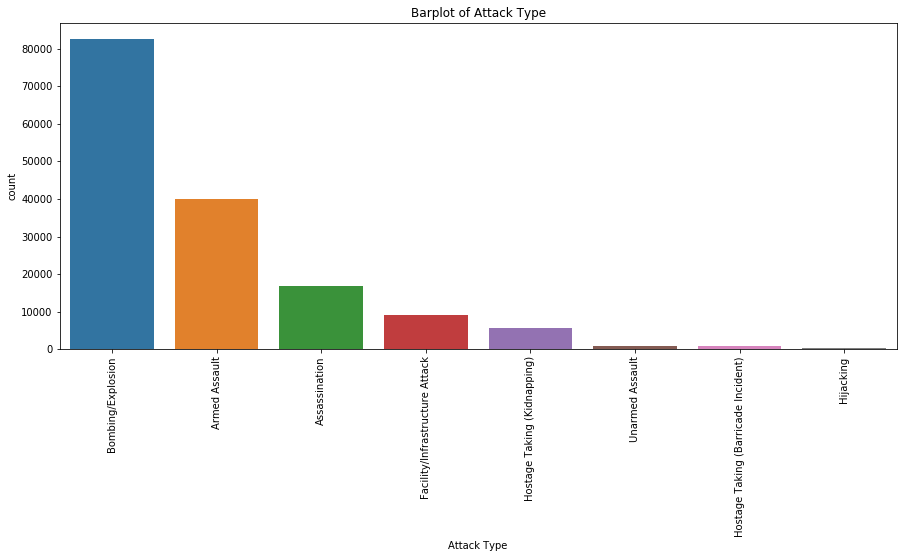

In [15]:
plt.subplots(figsize=(15, 6))
sns.countplot(data2.attacktype1_txt, order = data2.attacktype1_txt.value_counts().index)
plt.xticks(rotation = 90)
plt.title("Barplot of Attack Type")
plt.xlabel("Attack Type")
plt.show()

From the barplot, terrorist attacks in the form of bombing/ explosion happened with the highest frequency, followed by armed assault and assassination. Terrorist attacks in the form of facility/ infrastructure attack and hostage taking (kidnapping) also occurred with moderate frequencies. Hijacking, unarmed assault, and hostage taking (barricade incident) happened relatively less frequently.

#### Examining the Trend of Terrorist Attack

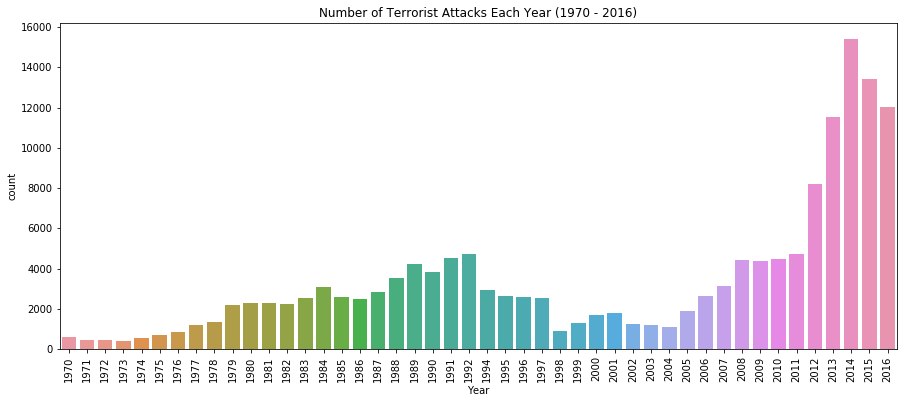

In [16]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.iyear)
plt.xticks(rotation = 90)
plt.title("Number of Terrorist Attacks Each Year (1970 - 2016)")
plt.xlabel("Year")
plt.show()

The plot shows a clear increasing trend in the number of terrorist attacks, peaking in 2014

According to the plot, the distribution of terrorist attacks by month is relatively uniform 

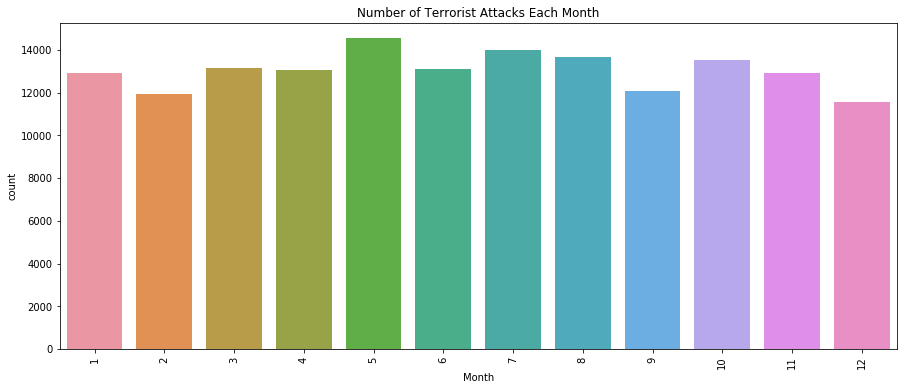

In [17]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.imonth)
plt.xticks(rotation = 90)
plt.title("Number of Terrorist Attacks Each Month")
plt.xlabel("Month")
plt.show()

#### Examining Distribution of Terrorist Attacks By Year and Regions

In [18]:
data2.pivot_table(index = "region_txt", columns = "iyear", values = "eventid", aggfunc = "count", fill_value = 0)

iyear,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region_txt,,,,,,,,,,,,,,,,,,,,,
Australasia & Oceania,1,1,2,1,1,0,0,0,2,2,...,1,8,1,1,0,0,1,9,14,10
Central America & Caribbean,1,4,3,3,9,9,41,16,151,398,...,4,0,9,1,1,1,14,5,1,3
Central Asia,0,0,0,0,0,0,0,0,0,0,...,4,34,29,8,9,12,7,8,9,16
East Asia,2,1,0,2,4,12,2,1,35,14,...,0,25,8,1,4,4,14,41,27,8
Eastern Europe,12,4,1,1,1,0,0,2,2,1,...,60,206,162,259,195,172,164,841,654,124
Middle East & North Africa,22,46,30,18,40,39,51,208,120,412,...,1370,1492,1336,1426,1601,2358,4407,6383,5258,5443
North America,469,246,67,61,107,153,117,144,106,74,...,19,30,15,23,12,38,32,33,62,72
South America,43,14,15,52,61,49,78,89,170,176,...,46,128,152,137,98,124,159,249,151,109
South Asia,1,0,1,0,2,3,4,2,2,29,...,924,1569,1747,1773,1969,3651,4418,4633,4188,3151


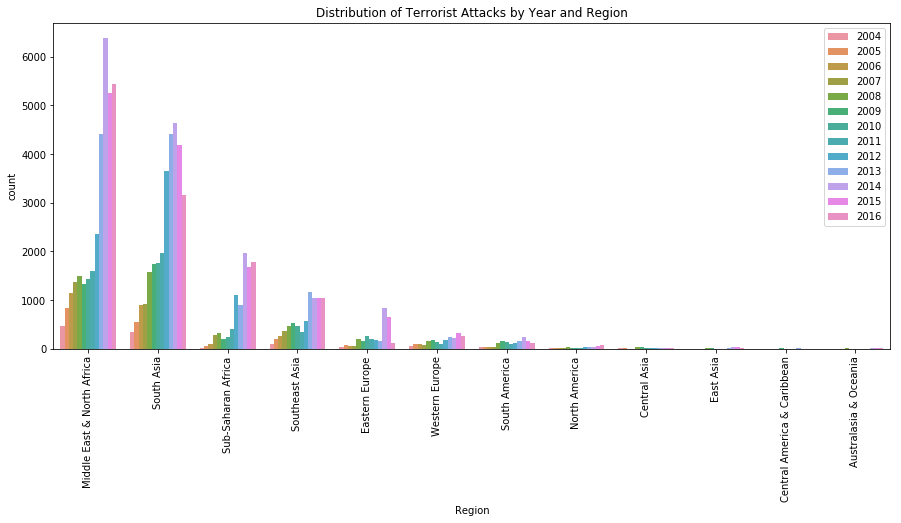

In [19]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.region_txt[data2.iyear.isin(np.arange(2004, 2017, 1))],\
              hue = data2.iyear[data2.iyear.isin(np.arange(2004, 2017, 1))],\
              order = data2.region_txt[data2.iyear.isin(np.arange(2004, 2017, 1))].value_counts().index)
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.title("Distribution of Terrorist Attacks by Year and Region")
plt.xlabel("Region")
plt.show()

#### Examining Distribution of Attack Types By Year

In [20]:
data2.pivot_table(index = "attacktype1_txt", columns = "iyear", values = "eventid", aggfunc = "count", fill_value = 0)

iyear,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
attacktype1_txt,,,,,,,,,,,,,,,,,,,,,
Armed Assault,61,44,63,62,46,81,124,255,241,442,...,846,1081,1101,1093,1388,2078,2958,4066,3339,2713
Assassination,17,67,191,158,155,177,198,141,244,442,...,137,202,220,355,334,449,830,873,885,780
Bombing/Explosion,333,238,187,149,281,369,418,630,639,1047,...,1863,2660,2566,2509,2589,5079,6672,8775,7608,7075
Facility/Infrastructure Attack,174,88,18,36,42,64,113,180,177,179,...,115,272,336,286,236,287,526,652,645,629
Hijacking,8,3,6,4,3,0,2,5,0,9,...,7,12,17,9,8,5,12,39,26,30
Hostage Taking (Barricade Incident),3,1,4,7,5,11,6,12,39,60,...,6,2,4,8,2,18,25,42,69,58
Hostage Taking (Kidnapping),3,1,6,7,4,5,3,2,3,18,...,167,189,114,189,162,284,470,920,738,672
Unarmed Assault,3,0,0,3,4,0,3,0,5,7,...,6,33,19,21,20,29,39,53,95,70


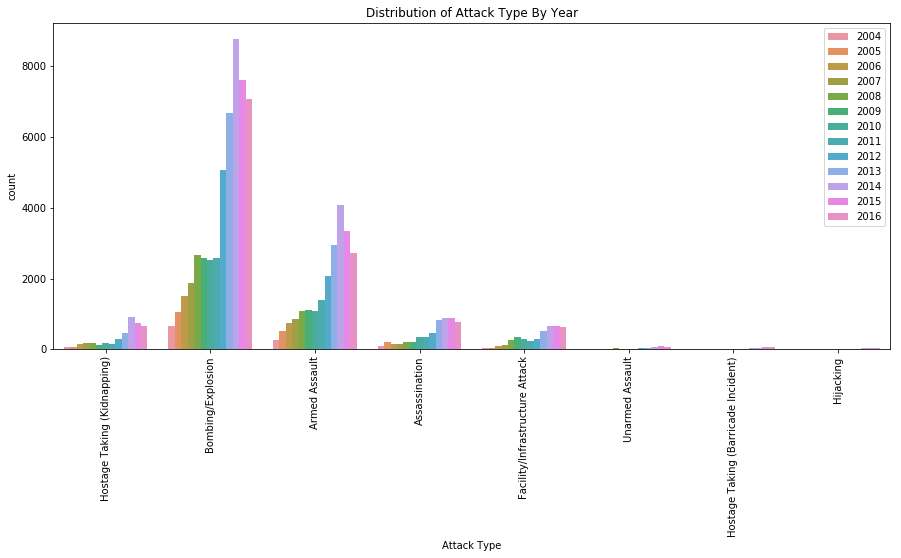

In [21]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.attacktype1_txt[data2.iyear.isin(np.arange(2004, 2017, 1))],\
              hue = data2.iyear[data2.iyear.isin(np.arange(2004, 2017, 1))])
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.title("Distribution of Attack Type By Year")
plt.xlabel("Attack Type")
plt.show()

#### Examining Distribution of Attack Types By Month

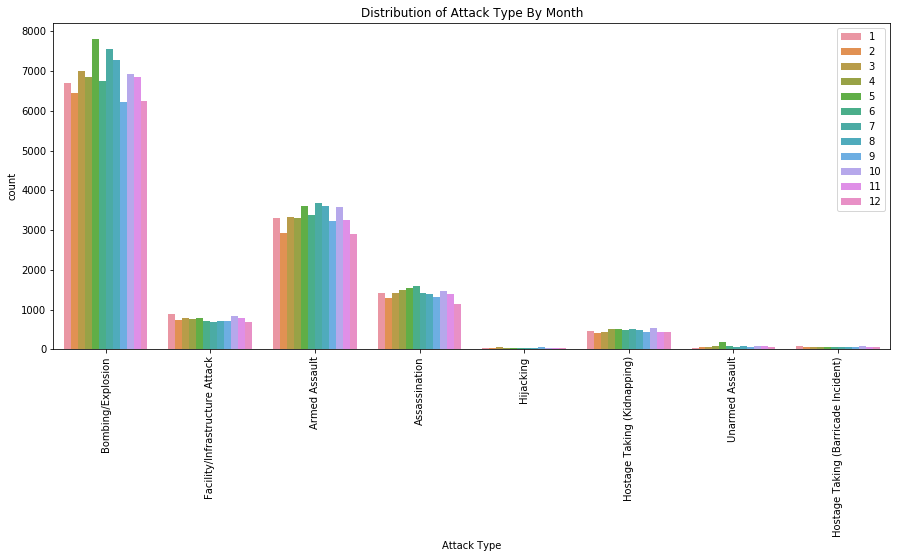

In [22]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.attacktype1_txt,\
              hue = data2.imonth)
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.title("Distribution of Attack Type By Month")
plt.xlabel("Attack Type")
plt.show()

#### Examining Distribution of Terrorist Attacks by Month and Regions

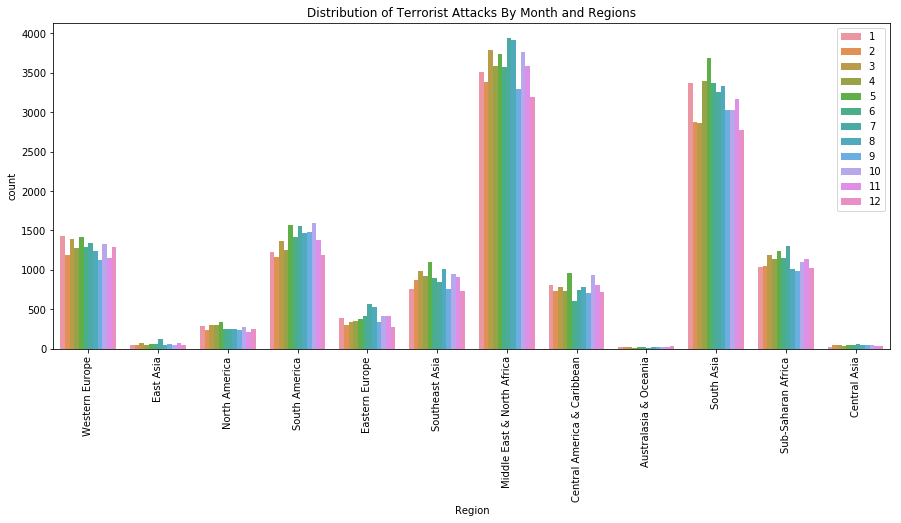

In [23]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.region_txt,\
              hue = data2.imonth)
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.title("Distribution of Terrorist Attacks By Month and Regions")
plt.xlabel("Region")
plt.show()

The distribution is relatively uniform for most the regions, but there may be some trends for regions such as South America, Middle East and North Africa, and South Asia

Also, there are usually spikes in every other month starting from January, suggesting a possibility of patterns in terrorist attacks

#### Examining Attack Types by Weapon Type

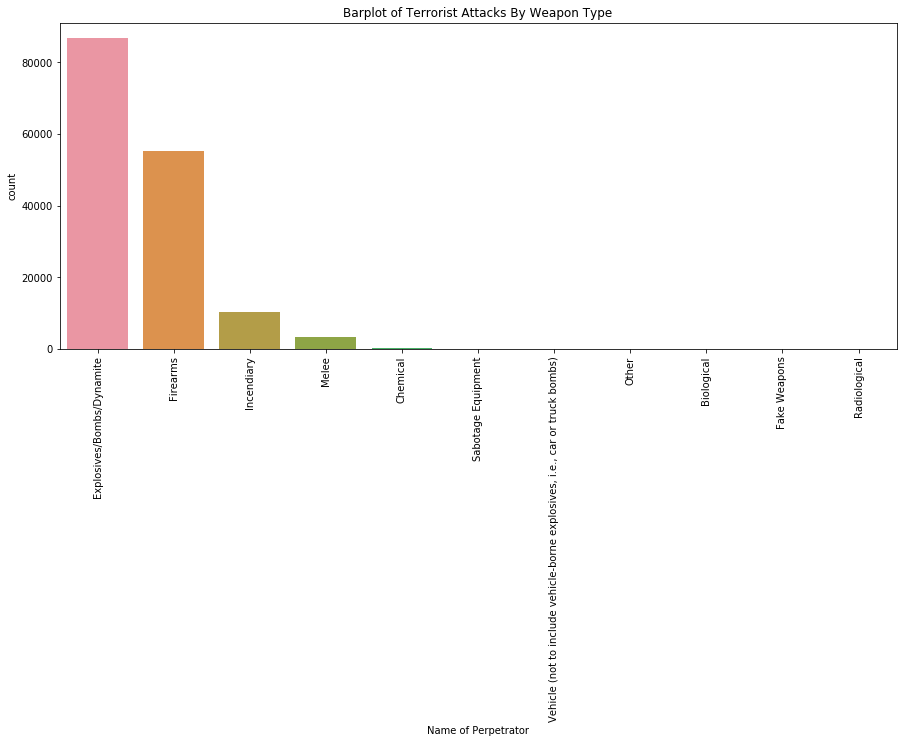

In [24]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.weaptype1_txt, order = data2.weaptype1_txt.value_counts().index)
plt.xticks(rotation = 90)
plt.title("Barplot of Terrorist Attacks By Weapon Type")
plt.xlabel("Name of Perpetrator")
plt.show()

From the barplot, the highest frequency of weapon type used in terrorist attacks are explosives/bombing/dynamite, followed by firearms. Incendiary (arson/fire), and melee (blunt objects, hands, feets, fists, knives, etc) occur relatively less frequently. 

#### Examining Target Types

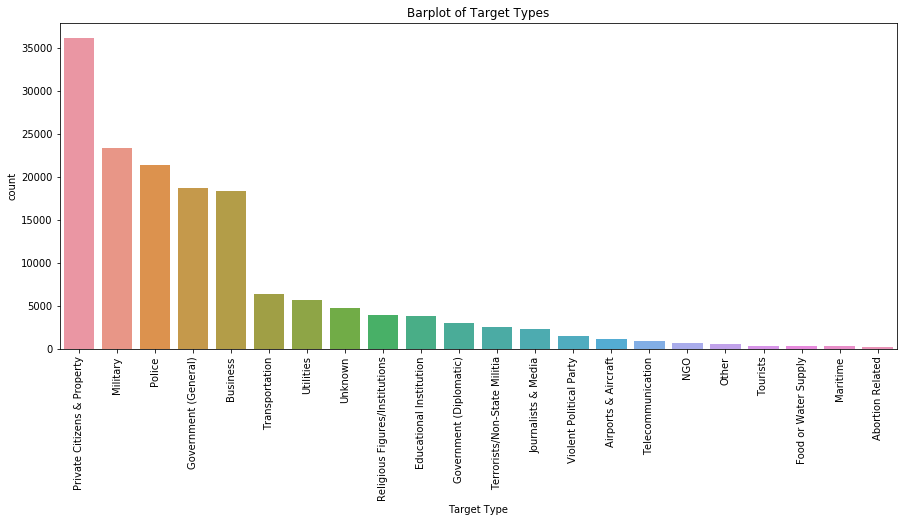

In [37]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.targtype1_txt, order=data2.targtype1_txt.value_counts().index)
plt.xticks(rotation = 90)
plt.title("Barplot of Target Types")
plt.xlabel("Target Type")
plt.show()

From the barplot, we can see that the highest frequency of target types are private citizens & property, followed by military, police, government, and business, which are around moderate frequency. The frequency continues to decrease for transportation, utilities, unkonwn, religious figures/institutions, then educational institutions, etc.

#### Examining Attack Types by Target Types

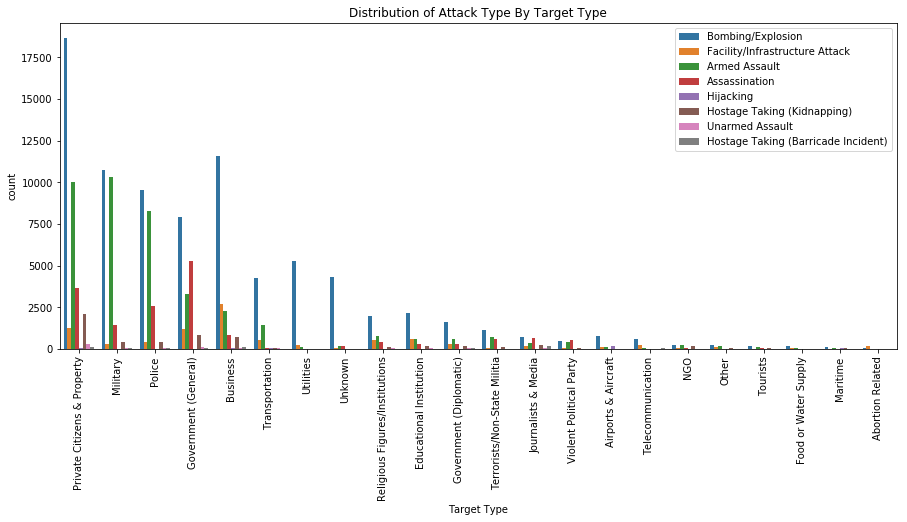

In [44]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.targtype1_txt, hue=data2.attacktype1_txt, order=data2.targtype1_txt.value_counts().index)
plt.xticks(rotation = 90)
plt.title("Distribution of Attack Type By Target Type")
plt.xlabel("Target Type")
plt.legend(loc="upper right")
plt.show()

The highest frequency of attack type by target type are bombings/explosions on private citizens & property, followed by bombings/explosions on business. Around similar frequencies to bombings/explosions on business are armed assault on private citizens & property, armed assault on military, and bombings/exposions on police. The next modterate frequencies are armed assault on police and bombing/explosions on government(general).

#### Examining Multiple Attack Types

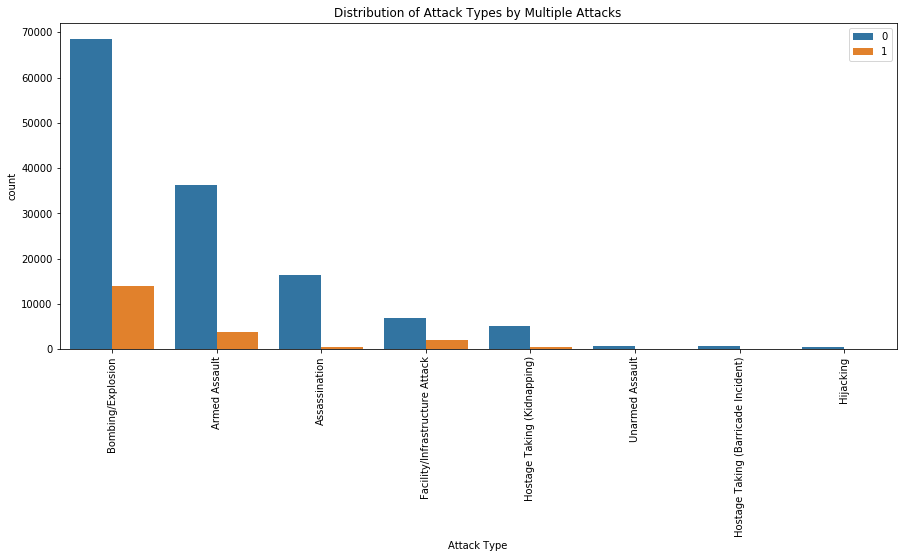

In [41]:
plt.subplots(figsize=(15,6))
sns.countplot(data2.attacktype1_txt,\
              hue = data2.multiple,\
             order = data2.attacktype1_txt.value_counts().index)
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")
plt.title("Distribution of Attack Types by Multiple Attacks")
plt.xlabel("Attack Type")
plt.show()

From the bar plot above, we can see that multiple attacks are most frequently in the form of bombings/explosions, followed by armed assault, assassination, facility/infrastructure attack, and finally, hostage taking (kidnapping).

### Multinomial Logistic Regression

#### Creating X and y Variables

In [ ]:
X_temp = data2.loc[:,["imonth", "crit1", "crit2", "crit3", "multiple", \
          "country_txt", "region_txt", "weaptype1_txt", \
          "suicide", "targtype1_txt", "target1", \
          "gname", "attacktype1_txt"]]
X_temp2 = X_temp.dropna()
X = X_temp2.loc[:,["imonth", "crit1", "crit2", "crit3", "multiple", \
          "country_txt", "region_txt", "weaptype1_txt", \
          "suicide", "targtype1_txt", "target1", \
          "gname"]]

In [ ]:
X["target1"] = X["target1"].astype(str)
X["gname"] = X["gname"].astype(str)

In [ ]:
y_temp = X_temp2.loc[:,"attacktype1_txt"]

In [ ]:
group = y_temp.unique()
print(group)

In [ ]:
# Binarize the output
y = label_binarize(y_temp, classes=group)
n_classes = y.shape[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 40)

In [ ]:
print(y_train.shape)
print(X_train.shape)

In [ ]:
print(y_temp.head())
print(y)

In [ ]:
le=LabelEncoder()

# Iterating over all the common columns in train and test
for col in X_test.columns.values:
    # Encoding only categorical variables
    if X_test[col].dtypes=='object':
    # Using whole data to form an exhaustive list of levels
        data3 = X_train[col].append(X_test[col])
        le.fit(data3.values)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

logreg = LogisticRegression(multi_class='ovr')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))

accuracy_score(y_test,logreg.predict(X_test))

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))